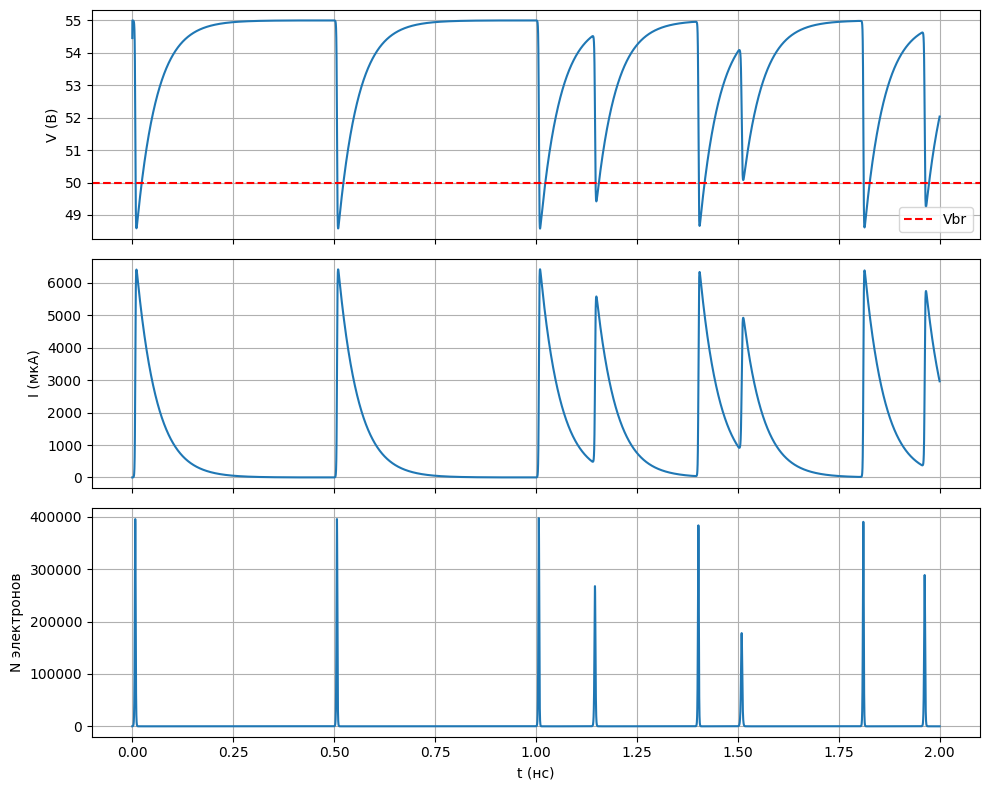

In [29]:
import numpy as np
import scipy.constants as ct
import matplotlib.pyplot as plt
class SPAD:
    def __init__(self, Vbr=50.0, V_power=55.0, R_power=10, Rq=100, Сquen=50e-15, Cjunc = 10e-18, dt=1e-12, Vscale=1.0, dark_rate=1e8, k_hole=0.5, p_photon=0.5):
        self.Vbr = Vbr # пороговое напряжение образования лавины
        self.V_power = V_power # напряжение питания
        self.R_power = R_power # сопротивление питания
        self.Rq = Rq # гасящий резистор
        self.Сquen = Сquen # ёмкость гасящего конденсатора
        self.Cjunc = Cjunc # ёмкость p-n перехода
        self.dt = dt # шаг по времени
        self.dark_rate = dark_rate # частота темновых всплесков
        self.Vscale = Vscale # масштабный фактор для коэффициента ионизации
    
        self.k_hole = k_hole # сотношение выбивание новых пар электронами и дырками

        self.N_oblastey = 10 # насколько мы точно моделируем область 
        # электроны бегут к 0, дырки к N

        self.active_electron = [0]*self.N_oblastey
        self.q_Cquen = 0 # заряд на конденсаторе
        self.q_Cjunc = 0 # заряд на переходе

        self.p_photon = p_photon # вероятность генерации электрона на один фотон

    def photon(self, N):
        n_photon = np.random.poisson(N*self.p_photon)
        for _ in range(n_photon):
            n = np.random.randint(self.N_oblastey)
            self.active_electron[n] += 1

    def dark_events(self):
        """
        Темновые срабатывания за один dt.
        Возвращает число сгенерированных пар.
        """
        mean_dark = self.dark_rate * self.dt * (self.q_Cjunc / self.Cjunc / self.Vbr)
        n_dark = np.random.poisson(mean_dark)

        for _ in range(n_dark):
            n = np.random.randint(self.N_oblastey)
            self.active_electron[n] += 1


    def sim_step(self):
        # Темновые события и фотонные возбуждения
        self.dark_events()

        # Активные электроны/дырки
        active_electron = self.active_electron.copy()
        active_holes = active_electron[::-1]
        new_electron = [0]*self.N_oblastey
        new_holes = [0]*self.N_oblastey

        # Напряжение на p-n переходе
        V_junc = self.q_Cjunc / self.Cjunc


        x = (V_junc - self.Vbr)/self.Vscale
        x = np.clip(x, -50, 50)   # предотвращаем overflow
        raw_alpha = np.exp(x)/self.N_oblastey
        alpha = raw_alpha/(1+raw_alpha)

        alpha_e = alpha
        alpha_h = self.k_hole * alpha

        # Лавинное умножение
        for i in range(self.N_oblastey):
            ne = active_electron[i]
            nh = active_holes[i]

            if ne > 0:
                lam_e = max(min(ne*alpha_e, 5e7), 0)
                k_e = np.random.poisson(lam_e)
                new_electron[i] += k_e
                new_holes[i] += k_e
                if i > 0:
                    new_electron[i-1] += ne
                else:
                    # зарядка гасящего конденсатора от лавины
                    self.q_Cquen += ne*ct.e

            if nh > 0:
                lam_h = max(min(nh*alpha_h, 5e7), 0)
                k_h = np.random.poisson(lam_h)
                new_electron[i] += k_h
                new_holes[i] += k_h
                if i < self.N_oblastey-1:
                    new_holes[i+1] += nh

        self.active_electron = new_electron

        # -------------------------------
        # Зарядка / разрядка конденсаторов
        # -------------------------------

        # Разрядка Cquen через гасящий резистор
        I_quench = self.q_Cquen / self.Сquen / self.Rq
        self.q_Cquen -= I_quench * self.dt

        # Зарядка Cjunc от источника
        I_source = (self.V_power - V_junc - self.q_Cquen/self.Сquen) / (self.R_power+self.Rq)
        self.q_Cjunc += I_source * self.dt


def run(spad, steps):
    t = np.arange(steps) * spad.dt
    V = np.zeros(steps)
    I = np.zeros(steps)
    Ne = np.zeros(steps)

    for i in range(steps):
        if(i % 5000 == 0):
            spad.photon(100)
        spad.sim_step()
        V[i] = spad.q_Cjunc / spad.Cjunc
        I[i] = spad.q_Cquen / spad.Сquen / spad.Rq
        Ne[i] = sum(spad.active_electron)

    return t, V, I, Ne

spad = SPAD(Vbr = 50.0, V_power = 55.0, R_power = 10, Rq = 1000, Сquen = 50e-15, Cjunc= 1e-16, dt = 1e-13, Vscale = 5.0, dark_rate = 5e9, k_hole=0.5)

t, V, I, Ne = run(spad, steps=20000)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t * 1e9, V)
axs[0].axhline(spad.Vbr, color='r', linestyle='--', label='Vbr')
axs[0].set_ylabel("V (В)")
axs[0].legend()
axs[0].grid()

axs[1].plot(t * 1e9, I * 1e6)
axs[1].set_ylabel("I (мкА)")
axs[1].grid()

axs[2].plot(t * 1e9, Ne)
axs[2].set_ylabel("N электронов")
axs[2].set_xlabel("t (нс)")
axs[2].grid()

plt.tight_layout()
plt.show()
        


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12500\1734468702.py:61: RuntimeWarning: overflow encountered in exp
  raw_alpha = np.exp((V - self.Vbr) / 1.0) / self.N_oblastey
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12500\1734468702.py:62: RuntimeWarning: invalid value encountered in scalar divide
  alpha = raw_alpha / (1.0 + raw_alpha)


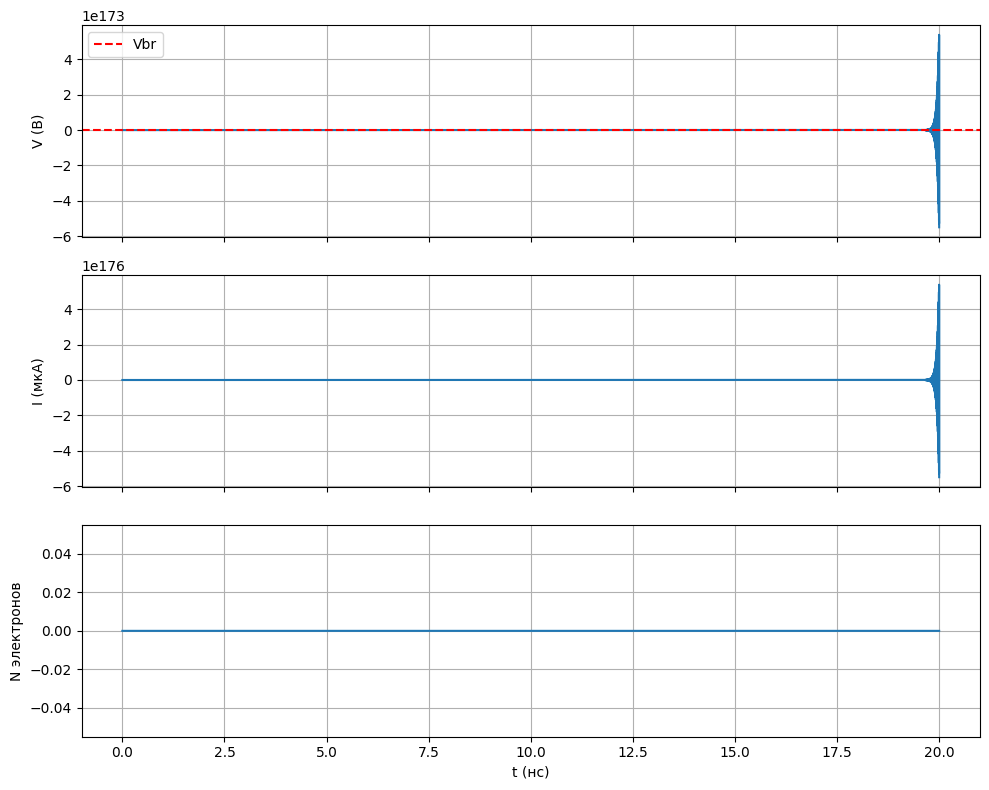